In [1]:
import numpy as np
import sklearn.datasets
import sklearn.linear_model
import sklearn.metrics
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,plot_roc_curve,precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFECV

In [2]:
np.random.seed(42)  # do not change for reproducibility

In this test we use the [Covertype Data Set](http://archive.ics.uci.edu/ml/datasets/Covertype), a dataset describing cartographic 
features of areas of land in the USA and also its forest type according to the US Forest Service. 
There are seven classes (1-7), 581012 samples and 54 features.
For this test, we're only interested in cover type 3.




In [3]:
dataset = sklearn.datasets.fetch_covtype()

In [4]:
# only use a random subset for speed - pretend the rest of the data doesn't exist
random_sample = np.random.choice(len(dataset.data), len(dataset.data) // 10)
COVER_TYPE = 3
features = dataset.data[random_sample, :]
target = dataset.target[random_sample] == COVER_TYPE

A junior colleague tells you that they're getting 96% accuracy using logistic regression. You review their work and see the following:

In [5]:
classifier = sklearn.linear_model.LogisticRegression(solver='liblinear') # do not change this


In [6]:
classifier.fit(features,  target)
training_predictions = classifier.predict(features)
accuracy = sklearn.metrics.accuracy_score(training_predictions, target)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.963


**Question 1**

Comment on what was done above. Evaluate the accuracy more thoroughly. Do not modify the parameters of the model (the cell marked with the comment). Use the classifier object.

#### The data is randomly sampled (58101 rows and 54 features ), along with the features and target ( covert type 3) data. 

1.) A Logistic regression classifier model with an hyperparameter Liblinear solver, is passed to the model, which helps in identifying the optimal parameter weights which can help minimize the cost function. 

2.) The developed model is a binary classification model, where the target is to predict whether the forest cover type is 3 or not.(interest of prediction is cover type 3)

3.) The above Model is build and validated on the same training data, where the accuracy is quite good as expected, but this is fundamentally incorrect and will yield in bad results because the objective of testing a model is to estimate how well it will perform predictions on data that the model didn't see. And here we are testing on the same data on which the model is build.We won't realise that our model is overfitting, because the performance of the model on the test set is good.

5.) Furthermore we shall check the distribution of the target label, whether it is balanced or imbalanced, because if the classes are highly imbalanced then accuracy could be a misleading evaulation metric.

#### We will be using the same subset of data used by the logistic regression model and evaulate the model accuracy without modifing the hyperparameters of the model.

In order to evaulate the model accuracy thoroughly , we shall split the data into training, validation and test data , where the model is trained on training data, selection of hyperparameters using validation data and testing on unseen or test data which the model has not been seen yet. This will help generalize the model better.

In [7]:
# Transformed the data into pandas dataframe 
data_forest = pd.DataFrame(data=features, columns=['Elevation','Aspect','Slope',
  'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
  'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon',
  'Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Wilderness_Area_0',
  'Wilderness_Area_1','Wilderness_Area_2','Wilderness_Area_3','Soil_Type_0',
  'Soil_Type_1','Soil_Type_2','Soil_Type_3','Soil_Type_4','Soil_Type_5','Soil_Type_6',
  'Soil_Type_7','Soil_Type_8','Soil_Type_9','Soil_Type_10',
  'Soil_Type_11',
  'Soil_Type_12',
  'Soil_Type_13',
  'Soil_Type_14',
  'Soil_Type_15',
  'Soil_Type_16',
  'Soil_Type_17',
  'Soil_Type_18',
  'Soil_Type_19',
  'Soil_Type_20',
  'Soil_Type_21',
  'Soil_Type_22',
  'Soil_Type_23',
  'Soil_Type_24',
  'Soil_Type_25',
  'Soil_Type_26',
  'Soil_Type_27',
  'Soil_Type_28',
  'Soil_Type_29',
  'Soil_Type_30',
  'Soil_Type_31',
  'Soil_Type_32',
  'Soil_Type_33',
  'Soil_Type_34',
  'Soil_Type_35',
  'Soil_Type_36',
  'Soil_Type_37',
  'Soil_Type_38',
  'Soil_Type_39'])
data_forest['Target'] = target
data_forest.Target.value_counts()
data_forest.iloc[:,0:54] = data_forest.iloc[:,0:54].astype(int)
data_forest

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Target
0,3021,26,16,60,7,3961,211,204,125,2496,...,0,0,0,0,0,0,0,0,0,False
1,3065,348,21,124,19,4725,177,202,159,624,...,0,0,0,0,0,0,0,0,0,False
2,3153,287,17,335,41,1298,171,237,205,2045,...,1,0,0,0,0,0,0,0,0,False
3,3172,156,29,716,291,1154,237,228,98,2837,...,0,0,0,0,0,0,0,0,0,False
4,3182,70,13,362,40,2992,234,214,109,4336,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58096,2937,2,16,170,28,2538,196,208,148,1943,...,0,1,0,0,0,0,0,0,0,False
58097,2841,85,22,162,19,295,245,197,71,201,...,0,0,0,0,0,0,0,0,0,False
58098,3034,102,7,268,133,2522,232,231,132,1766,...,0,1,0,0,0,0,0,0,0,False
58099,3272,329,11,60,10,4650,194,227,173,836,...,1,0,0,0,0,0,0,0,0,False


In [8]:
"""
If we check the class distribution, it is highly imbalanced.94% of the instances are not 
forest cover type 3 and 6% of instances are forest cover type 3.
"""
data_forest.Target.value_counts()

False    54560
True      3541
Name: Target, dtype: int64

In [9]:
"""
Lets split the data into Train and Test Split into 80% Training 
data and 20% of test data. While splitting the data we are trying to split the data using
Stratified approach on the target variable, reason behind we would like to maintain the
same proportion of samples in both sets of data.
"""
def prep_data(x_data):
    
    x = x_data.drop('Target', axis = 1) 
    y = x_data['Target']
    
    x_tr, x_tst, y_tr, y_tst = train_test_split(x, y, stratify=y, test_size = 0.2, random_state = 42)
    return x_tr, x_tst, y_tr, y_tst

x_train, x_test, y_train, y_test = prep_data(data_forest)

In [10]:
def display_confusion_matrix(y_true, y_hat):
    
    cm = confusion_matrix(y_true, y_hat)
    ax=plt.subplot();
    sns.heatmap(cm, annot=True, fmt='d', linewidths=2, linecolor='black', cmap='YlGnBu',ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(2.0,0)
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Neg','Pos'])
    ax.yaxis.set_ticklabels(['Neg','Pos'])
    plt.show()

In [11]:
"""
Building a model on training data and predicting on test data. Further evaulating the model.
"""
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

False    11025
True       596
Name: 0, dtype: int64
Accuracy: 0.962
F1_Score: 0.661
Precision_Score: 0.723
Recall_Score: 0.609


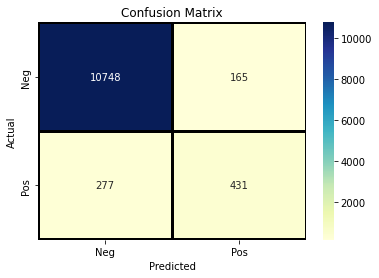

              precision    recall  f1-score   support

       False       0.97      0.98      0.98     10913
        True       0.72      0.61      0.66       708

    accuracy                           0.96     11621
   macro avg       0.85      0.80      0.82     11621
weighted avg       0.96      0.96      0.96     11621



In [12]:
"""
Model accuracy on test data is 96% at threshold of 0.5, which means that the model is really good 
enough, because we have similar performance on both training and testing data.

However, if we observe in detail we can see that the model learned to classify 
mostly towards negative class (majority class), which generates that effect of having a 
good enough accuracy.The higher accuracy is not due to correct classification. 
The model has predicted the majority class for almost all the instances.

As we can see that precsion, recall,F1 score for predicting the negative class instance is higher compared
class 1 (postive class for predicting forest covert type as 3), indicating high biased
towards the positive class.

Below results shows that Logistic Regression predicted 596 instances 
of positive class,whereas 11025 instances of negative class. The biasness towards the 
majority class (negative instances) and severe skewness in the results is responsible for 
higher accuracy(96%).Here accuracy is misleading the model and as the data is highly 
imbalanced and skewed, we need to look into other relevant metric as this is misleading.

Considering Recall, Precision and F1 score are high for negative classes compared to 
positive classes.This metric help us in evaluating the model performance when there is a
biasness or imabalancement in the data.

For such a scenario,we shall also look at the PR Curve (Precision Recall Curve) compared 
to ROC Curve, which will help interpret the model results accurately instead of misleading
in scenarios of highly imbalance dataset.

To further evaluate the model considering the imbalanced class distribution, we shall 
consider the F1 score which is a balance of precision and recall
and would be much appropriate compared to accuarcy and help build an efficient model.

"""
predictions = pd.DataFrame(y_pred)
print(predictions[0].value_counts())

accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

f1_score = sklearn.metrics.f1_score(y_test, y_pred)
print(f'F1_Score: {f1_score:.3f}')

precision_score = sklearn.metrics.precision_score(y_test, y_pred)
print(f'Precision_Score: {precision_score:.3f}')

recall_score = sklearn.metrics.recall_score(y_test, y_pred)
print(f'Recall_Score: {recall_score:.3f}')

display_confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred))

ROC AUC Score 0.9814208524431288


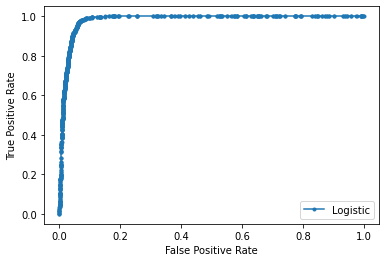

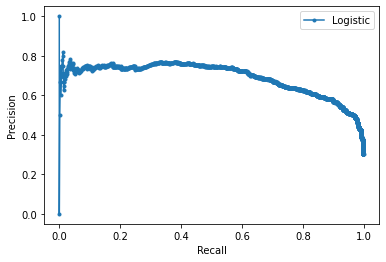

In [13]:
"""
Lets check the ROC curve and ROC AUC score for this imbalanced data.The by default 
threshold used for classifying the target label is 0.5. 

We plot ROC AUC curve and PR AUC Curve for every probability thresholds.
Results shows that ROC curve is showing a better performance, though there is an 
imbalance distribution,but if we look at the PR (Precision Recall curve) the area under 
the curve is low compared to ROC AUC curve,considering the fact that PR curve focuses on 
the minority class,whereas the ROC curve covers both classes making precision-recall 
curves being a good evauluator for imbalanced datasets.
"""


yhat = classifier.predict_proba(x_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

roc_auc = sklearn.metrics.roc_auc_score(y_test, pos_probs)
print("ROC AUC Score",roc_auc)

fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, pos_probs)
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()


precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, pos_probs)
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [14]:
"""
To further evaulate the model accuracy, we used train test split approach with stratified 
sampling on target variable. Using this approach model was build and tested on a single 
train-test split but using Stratified K fold Cross validation would help evaulate the model in a more better way, as
it would evaulte the model multiple train-test splits and we would get an idea on the 
overall accuracy of the model.

Looking at the Cross validation results we see that average scores for every k folds
is around 96%, which indicates that every subset of data represents the same trends.
"""
score_output = []
def evaluate_model(X, y, metric, classifier_obj):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(classifier_obj, X, y, scoring=metric, cv=cv, n_jobs=-1)
    score_output.append(scores)
    return scores, score_output
 
scores, score_output = evaluate_model(x_train, y_train, 'accuracy',classifier)
print(score_output)
print('Accuracy: %.3f%%' %(np.mean(scores) * 100))

[array([0.96084337, 0.96256454, 0.95740103, 0.96342513, 0.96127367,
       0.96127367, 0.9595525 , 0.96450086, 0.96019793, 0.95740103,
       0.95826162, 0.96557659, 0.96299484, 0.96127367, 0.9623494 ,
       0.95567986, 0.96320998, 0.96170396, 0.96901893, 0.96148881,
       0.96084337, 0.96385542, 0.96170396, 0.96557659, 0.95869191,
       0.96536145, 0.95697074, 0.96170396, 0.95654045, 0.96493115])]
Accuracy: 96.154%


#### Considering the above results, we observe that accuracy as an evaulation metric for  predicting forest cover type could be misleading.

The below approaches can be considered to evaulate the model in a more better way:

1.) To further improve we could add more data instances, considering we have only included subset of the main dataset.The random sampling of the data could have resulted in such imbalancement. This might help in evaulating the model accuracy in a better way considering a balance distribution of the class. We will be add more training data in the next iteration of algorithm and check the results. 

2.) To improve the model accuracy, we could try to balance the classes using SMOTE or any 
other sampling techniques, which would help better improve the metric.

3.) We can modify the current training algorithm, by using class weight approach within, which will take into account the skewed distribution of the classes.This can be achieved by giving different weights to both the majority and minority classes. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

4.) Relevant Feature engineering and identifying the relevancy of the features with the target variable would also improve the model performance.

5.) Different algorithms could also be tried in order to deal with such imbalanced datasets, in my opinion decision trees really perform well on imbalance data.


**Question 2**

Should you get more training data?

#### Looking at the above results, we see that accuarcy is misleading the models performance due to its imbalance class distribution. 

####  Here adding more training data for positive instance from the population data or the main dataset would not be feasible because the population data also has similar imbalance data distribution  of forest cover type. In that case will not be possible to get more positive class instances from the population data.

#### And besides evaulating the model only on accuracy metric we shall use F1 score or Precision or Recall, which could truely reflect the model performance. There are multiple possibilities of improving the performance of the model as below:

1.) We could try doing is adding more instances to the training data by oversampling the minority class or downsample the majority or negative class.

2.) We could try using some other ensemble algorithms like Random Forest and boosting algorithms to improve the model performance.But for this task we will be using Logistc Regression Classifier and will showcase different techniques to handle biased data and how could we improve the model performance.

3.) We could also modify the current algorithm to take into account the skewed distribution of the classes. This can be achieved by giving different weights to both the majority and minority classes and any misclassification in the minority class would be penalized more compared to majority class.

4.) Using other evaulation metric other than accuracy to validate the performance of the model.

4.) Below code snippet will be implementing one of the approach as mentioned above.The other approached could also yield in a better result.For this exercise I will be focussing more on how does the model performance behave if we add more data or try to use some sampling techniques to avoid the above problem that we faced in Question1. We will be using the same Logistic Regression Classifier Model, but other models could also be used and tried.

5.) But there also drawbacks of adding more samples using feasible techniques like SMOTE or undersampling techniques, as the positive instances are itself low compared to other cover type distribution in the population data. As seen in the above results recall is lower for the positive class compared negative class and that's the reason F1-score is also low.

6.) To avoid this issue we could use class weights hyperparameter to control the trade-off between precision and recall, which in other terms, is the same as handling class imbalance.

7.) Fine tuning the hyperparameters of the model will help in improving the model performance.

In [15]:
"""
On a higher level looking at the distribution of the forest cover type, we see there is 
imbalance distribution in the main dataset itself.
"""
unique, counts = np.unique(dataset.target, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     1 211840]
 [     2 283301]
 [     3  35754]
 [     4   2747]
 [     5   9493]
 [     6  17367]
 [     7  20510]]


In [16]:
mainData = pd.DataFrame(dataset.data, columns=['Elevation','Aspect','Slope',
  'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
  'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon',
  'Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Wilderness_Area_0',
  'Wilderness_Area_1','Wilderness_Area_2','Wilderness_Area_3','Soil_Type_0',
  'Soil_Type_1','Soil_Type_2','Soil_Type_3','Soil_Type_4','Soil_Type_5','Soil_Type_6',
  'Soil_Type_7','Soil_Type_8','Soil_Type_9','Soil_Type_10','Soil_Type_11','Soil_Type_12',
  'Soil_Type_13','Soil_Type_14','Soil_Type_15','Soil_Type_16','Soil_Type_17',
  'Soil_Type_18','Soil_Type_19','Soil_Type_20','Soil_Type_21','Soil_Type_22',
  'Soil_Type_23','Soil_Type_24',
  'Soil_Type_25',
  'Soil_Type_26',
  'Soil_Type_27',
  'Soil_Type_28',
  'Soil_Type_29',
  'Soil_Type_30',
  'Soil_Type_31',
  'Soil_Type_32',
  'Soil_Type_33',
  'Soil_Type_34',
  'Soil_Type_35',
  'Soil_Type_36',
  'Soil_Type_37',
  'Soil_Type_38',
  'Soil_Type_39'])

mainData['Target'] = dataset.target
mainData.iloc[:,0:54] = mainData.iloc[:,0:54].astype(int)
mainData

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Target
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [17]:
"""
Looking at the overall distribution of forest cover type, similar imbalance 
distribution is observd for the population data.Forest cover type is having 6% (35754/581012)
among all the other cover types. The subset of sample (forrest cover type 3 having approx
6% of instances) that was taken above is having similar distribution like the population.

In this case we could downsample the negative instances (majority class) or upsample the 
minority or positive class which indicates that the forest cover type is 3.

"""
mainData.Target.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Target, dtype: int64

In [18]:
"""
Filter the Forest Cover type as 3 and label the target variable
"""
mainData['Target_Label'] = np.where(mainData['Target'] == 3, 1, 0)
mainData

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Target,Target_Label
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,5,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,5,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,2,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,2,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,3,1
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,3,1
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,3,1
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,3,1


In [19]:
x = mainData.drop('Target_Label', axis = 1) 
y = mainData['Target_Label']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 42,stratify=y) 

#### Oversampling instances of the positive class, to further check the performance of the model.

1.) To further improve the performance of the model we are increasing the samples of the positive instances using smote, and in order to avoid inaccurate model accuracies smote is applied on training data and not on testing data. This will help in balancing the class distribution of the target variables.Sampling strategy is kept as 0.8 ratio as to the number of samples in the minority class over the number of samples in the majority class, basically not to have equal samples in both classes.

2.) Using the same classifier object which was used above,model is built on the new smote train samples, while evaulating the model, we will not consider accuracy only , would be looking into other relevant metrices as to have alook how did the model perform on both the class individually.

3.) Here the accuracies are quite good on both sets of data, we have got 67% of F1 score for the positive class , slight improvement than the above results we got, but we see a drop in recall with a higher precision for positive class which indicates lower false positive but higher false negatives.As still the data is imbalanced,the metrices are not showing much improovement.

Accuracy score for Training Dataset =  0.9505304583720723
Accuracy score for Testing Dataset =  0.9404490417631214


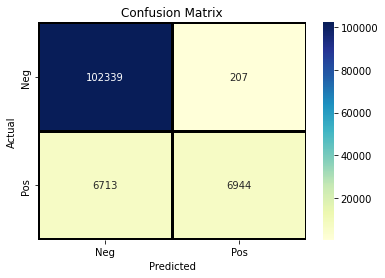

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    102546
           1       0.97      0.51      0.67     13657

    accuracy                           0.94    116203
   macro avg       0.95      0.75      0.82    116203
weighted avg       0.94      0.94      0.93    116203



In [20]:

oversample = SMOTE(random_state= 42, sampling_strategy=0.8)
X_train_smote, Y_train_smote = oversample.fit_resample(X_train, Y_train)

classifier.fit(X_train_smote, Y_train_smote)

# prediction for Training data
train_pred_sm = classifier.predict(X_train_smote)

# prediction for Testing data
test_pred_sm = classifier.predict(X_test)

print('Accuracy score for Training Dataset = ', sklearn.metrics.accuracy_score(train_pred_sm, Y_train_smote))
print('Accuracy score for Testing Dataset = ', sklearn.metrics.accuracy_score(test_pred_sm, Y_test))

display_confusion_matrix(test_pred_sm,Y_test)
print(classification_report(test_pred_sm,Y_test))

#### Trying to reducing the instances of negative class to have a balanced data using RandomUnderSampler.

1.) Downsampling the negative instances,are also yielding the similar results like oversampling the minority class, where accuracy on both sets of data are quite good,but recall is dropping and F1 score for positive class is similar to what we see.

0    35753
1    28603
Name: Target_Label, dtype: int64
Accuracy score for Training Dataset =  0.9597551121884518
Accuracy score for Testing Dataset =  0.9436589416796468


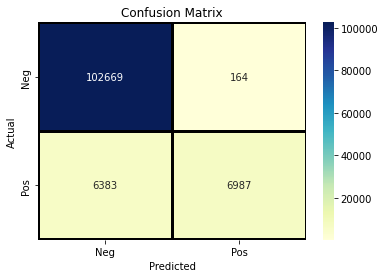

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    102833
           1       0.98      0.52      0.68     13370

    accuracy                           0.94    116203
   macro avg       0.96      0.76      0.83    116203
weighted avg       0.95      0.94      0.94    116203



In [21]:
under = RandomUnderSampler(random_state=42,sampling_strategy=0.8) 
                     
X_train_undersamp, y_train_undersamp = under.fit_resample(X_train, Y_train)
print(y_train_undersamp.value_counts())


classifier.fit(X_train_undersamp, y_train_undersamp)

# prediction for Training data
train_pred_undersamp = classifier.predict(X_train_undersamp)

# prediction for Testing data
test_pred_undersamp = classifier.predict(X_test)

print('Accuracy score for Training Dataset = ', sklearn.metrics.accuracy_score(train_pred_undersamp, y_train_undersamp))
print('Accuracy score for Testing Dataset = ', sklearn.metrics.accuracy_score(test_pred_undersamp, Y_test))

display_confusion_matrix(test_pred_undersamp,Y_test)
print(classification_report(test_pred_undersamp,Y_test))

#### With the help of class weights hyperparameter we will try to performance of the model . The class weights purposely increasing the power of the minority class and reducing the power of the majority class by modifying the loss functions. Therefore, it gives better results than SMOTE. Instead of adding more data, we could apply weights in the coefficients, which shall apply penality on misclassifying.

1.) As seen below in the results, to achieve a better F1-score the class weight parameters for the target labels are fine tuned based on grid search cross validation.Looking at the confusion matrix, precision , recall and F1-score are having a quite good score of approx 77%. Any misclassification within the minority class would be penalized heavily compared to any misclassification in the majority class.

2.) Using the class weight hyperparameter we are able to achieve good performance of the model

3.) To improve the model performance, add more instances to the training data, did not yield into potential results,using penalised based approach helped us with much better results for F1 score, precision and recall.

In [ ]:
"""
The belo code is performing a grod search to find the optimal weights,
which could help improve the performnace of the model.
"""

def grid_search_logistic_regression(x_tr, y_tr):
    
    #Setting the range for class weights
    weights = np.linspace(0.0,0.99,50)

    param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}
    
    log_primal_Grid = GridSearchCV(sklearn.linear_model.LogisticRegression(random_state=42, solver='liblinear'),param_grid, 
                                   scoring = 'f1', refit=True, verbose=0,
                                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True), 
                                   n_jobs=-1, error_score='raise').fit(x_tr, y_tr)
    
    print("Best Score -----",log_primal_Grid.best_score_)
    print("Best Parameter ---- ",log_primal_Grid.best_params_)
grid_search_logistic_regression(X_train,Y_train)

In [22]:
lr_bal=sklearn.linear_model.LogisticRegression(random_state=42,solver='liblinear',class_weight = {0: 0.32326530612244897, 1: 0.676734693877551})
lr_bal_model=lr_bal.fit(X_train,Y_train)
y_pred_bal=lr_bal_model.predict(X_test)
print('Classification report for balanced classes \n',classification_report(Y_test, y_pred_bal))

y_pred_bal_train = lr_bal_model.predict(X_train)
print('Accuracy score for Training Dataset = ', sklearn.metrics.accuracy_score(Y_train, y_pred_bal_train))
print('Accuracy score for Testing Dataset = ', sklearn.metrics.accuracy_score(Y_test, y_pred_bal))



Classification report for balanced classes 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    109052
           1       0.70      0.87      0.77      7151

    accuracy                           0.97    116203
   macro avg       0.84      0.92      0.88    116203
weighted avg       0.97      0.97      0.97    116203

Accuracy score for Training Dataset =  0.9692045549892536
Accuracy score for Testing Dataset =  0.9687701694448508


**Question 3**

How would you decide which features to include in the deployed model?

#### To identify the relevant features and derive new features lot of exploratory analysis will be done further, but for this task I have derived new features from existing features and using few techniques tried to come up with set of relevant features which could be used final model building.

##### There are various techniques for performing feature selection like:
1.) Correlation matrix

2.) Model based feature importance

3.) Filter and Wrapper methods

4.) PCA

5.) Statistical methods like p-value, Statistical Tests

6.) Visualizations like Box Plots, Scatter Plots and many more



## Understanding & Data Cleanup

In [25]:
"""
1.) In total there are 581012 records records with 54 variables and all the data is formatted and clean. There aren’t any null values and all features are numeric.
There are one-hot-encoded columns for soil type, Wilderness Area.

2.) There are no duplicates or any missing values in the data.

"""
mainData['Target_Label'] = np.where(mainData['Target'] == 3, 1, 0)
mainData['Target_Label_Name'] = np.where(mainData['Target_Label'] == 1, "ForestCoverType_3","Not_ForestCoverType_3")
print(mainData.shape)
print(mainData.dtypes)
mainData.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1])

(581012, 57)
Elevation                              int64
Aspect                                 int64
Slope                                  int64
Horizontal_Distance_To_Hydrology       int64
Vertical_Distance_To_Hydrology         int64
Horizontal_Distance_To_Roadways        int64
Hillshade_9am                          int64
Hillshade_Noon                         int64
Hillshade_3pm                          int64
Horizontal_Distance_To_Fire_Points     int64
Wilderness_Area_0                      int64
Wilderness_Area_1                      int64
Wilderness_Area_2                      int64
Wilderness_Area_3                      int64
Soil_Type_0                            int64
Soil_Type_1                            int64
Soil_Type_2                            int64
Soil_Type_3                            int64
Soil_Type_4                            int64
Soil_Type_5                            int64
Soil_Type_6                            int64
Soil_Type_7                            int

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Target,Target_Label
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471,0.061537
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504,0.240314
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
85%,3232.000000,312.000000,22.000000,488.000000,98.000000,4224.000000,237.000000,243.000000,182.000000,3097.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
90%,3272.000000,329.000000,24.000000,564.000000,121.000000,4793.000000,241.000000,247.000000,191.000000,3747.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
100%,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000


In [26]:
"""
Checking for Duplicates - There are no duplicate records found.
"""
def check_duplicates(x):

    return x.loc[x.duplicated()]
duplicate_records = check_duplicates(mainData)

"""
There are no missing values in the data
"""
def per_missing_val(x):
    
    
    percent_missing = x.isnull().sum() * 100 / len(x)
    x_df = pd.DataFrame({'column_name': x.columns,
                                     'percent_missing': percent_missing})
    x_df = x_df.sort_values('percent_missing',ascending =False)
    return x_df

missing_data = per_missing_val(mainData)



## Explorator Data Analysis

#### Visualizing the relationship between Continuos Varaibles and Target Variables

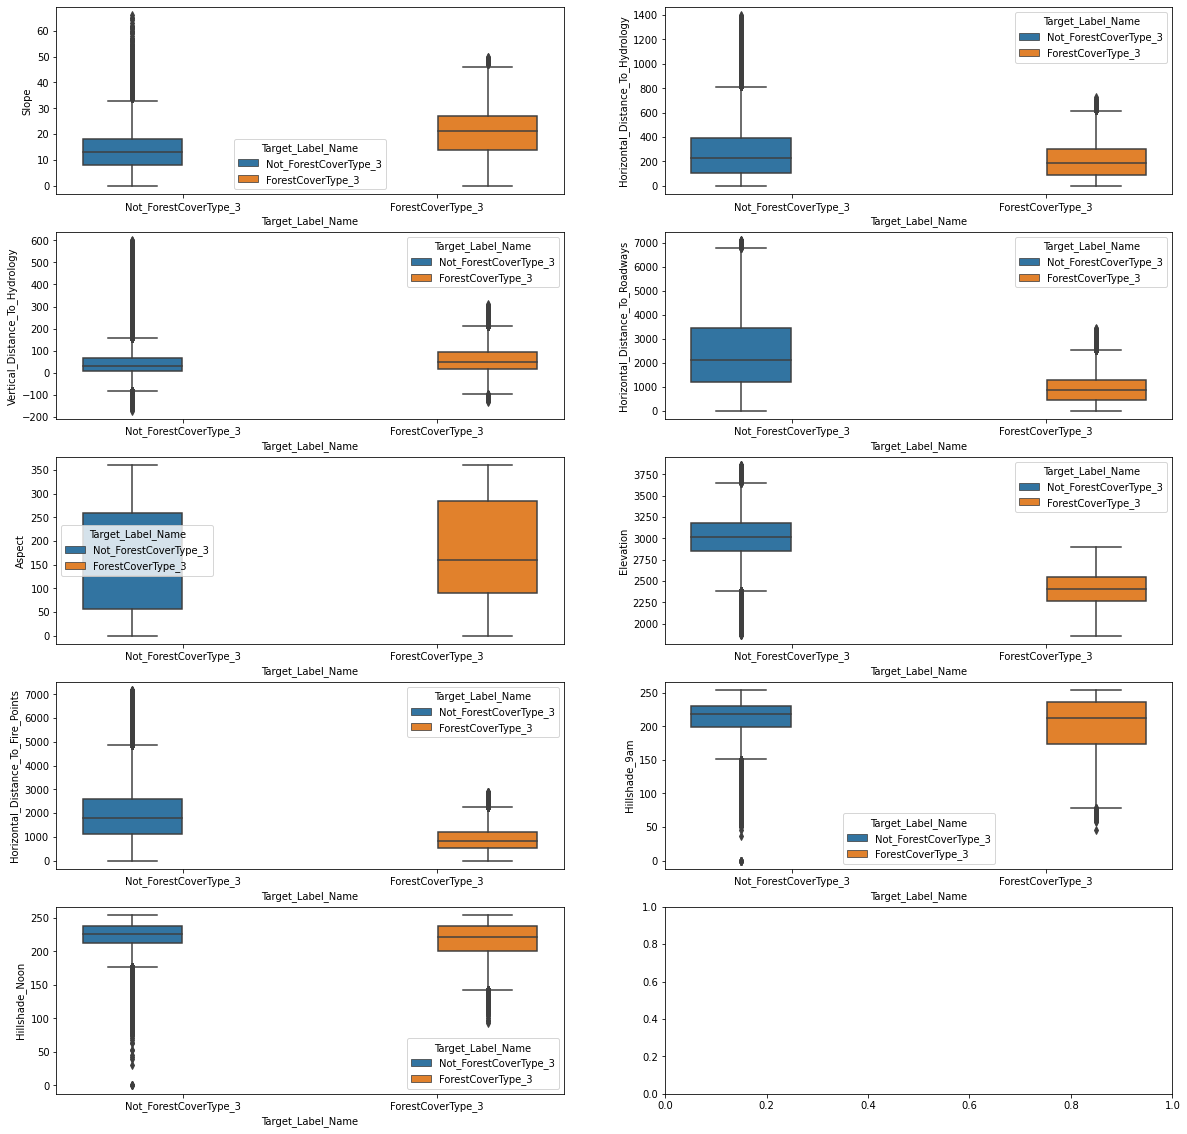

In [27]:

"""
Visualizing the relation between Target Variable and Continuos Variable.
With the below results we observe that features like: 
Elevation,
Slop,
Vertical_Distance_To_Hydrology,
Aspect, 
Horizontal_Distance_To_Roadways and 
Horizontal_Distance_To_Fire_Points 
are related to the target variable.There is a difference between the mean samples of 
both groups, which indicates there is a relationship between the 2 variables.

For example higher values of Slope are classified as forest cover type 3 compared 
to non-forest cover type3 and similary for other features where we see different 
within the sample groups.

There is no significant relationship between the Horizontal_Distance_To_Hydrology and 
target sample groups.Similarl insights for Vertical_Distance_To_Hydrology.

"""

fig, axarr = plt.subplots(5, 2, figsize=(20, 20))
sns.boxplot(y='Slope',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData, ax=axarr[0][0])
sns.boxplot(y='Horizontal_Distance_To_Hydrology',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData , ax=axarr[0][1])
sns.boxplot(y='Vertical_Distance_To_Hydrology',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData, ax=axarr[1][0])
sns.boxplot(y='Horizontal_Distance_To_Roadways',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData, ax=axarr[1][1])
sns.boxplot(y='Aspect',x = 'Target_Label_Name',hue = 'Target_Label_Name',data = mainData, ax=axarr[2][0])
sns.boxplot(y='Elevation',x = 'Target_Label_Name',hue = 'Target_Label_Name',data = mainData, ax=axarr[2][1])
sns.boxplot(y='Horizontal_Distance_To_Fire_Points',x = 'Target_Label_Name',hue = 'Target_Label_Name',data = mainData, ax=axarr[3][0])
sns.boxplot(y='Hillshade_9am',x = 'Target_Label_Name',hue = 'Target_Label_Name',data = mainData, ax=axarr[3][1])
sns.boxplot(y='Hillshade_Noon',x = 'Target_Label_Name',hue = 'Target_Label_Name',data = mainData, ax=axarr[4][0])








#### Distribution and relationship of continuous variables (Elevation, Aspect, Slope, Distance and Hillshade columns)

In [28]:
"""
Soil type and wilderness area columns are discrete, and both are the one-hot-encoded 
version of one categorical feature.

Rest of the features are addressed as continuous: Elevation, Aspect, Slope, 
Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, 
Horizontal_Distance_To_Roadways, Hillshade_9am, Hillshade_Noon, Hillshade_3pm, 
Horizontal_Distance_To_Fire_Points

Checking Multicollinearity using correlation matrix.

Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology are highly positively
correlated.Having multicollinearity issue we could delete one of the hightly correlated
varibale or create a new feature from the existing 2 variable which is more informative 
than those 2. We will combine the 2 features using Pythogorean
theorem which will yield to "Distance to Hydrology" new feature.This feature carries much 
more information rather than simple horizontal and vertical notions, because obviously 
cover type of land should depend on direct distance to water source.

All Hillshade features are collinear,those pairs provide the same input to the model, 
for a better interpretability, one of them will be dropped in the Feature Engineering & 
Selection. 

Slope has a negative trend with Elevation,Horizontal_Distance_To_Roadways,Hillshade_9am, 
Hillshade_Noon,Hillshade_3pm and Horizontal_Distance_To_Firepoints. But they are not highly
correlated.

Aspect is highly correlated with all Hillshade features with a positve and negative trend.

There are some highly collinear features (having coefficient above 0.5) like :

vertical distance to hydrology - horizontal distance to hydrology
hillshade noon - hillshade 3 pm
hillsahde 3 pm - hillshade 9 am
Hillshade_9am - Aspect
Hillshade_Noon- Slope

"""


continuous_variables = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3','Target_Label']

def corr_func(x, cols):
    correlation_data = x[cols].corr()
    return correlation_data
    
corr_func(mainData, continuous_variables)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Target_Label
Elevation,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022,0.131838,0.238164,0.066550,-0.619374,-0.516612
Aspect,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172,-0.140123,0.055988,0.074904,0.082687,0.047400
Slope,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662,-0.234576,-0.036253,0.125663,0.255503,0.227971
Horizontal_Distance_To_Hydrology,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874,-0.097124,0.055726,0.122028,-0.100433,-0.071264
Vertical_Distance_To_Hydrology,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913,-0.180710,-0.008709,0.146839,0.077792,0.070406
Horizontal_Distance_To_Roadways,0.365559,0.025121,-0.215914,0.072030,-0.046372,1.000000,0.034349,0.189461,0.106119,0.331580,0.453913,-0.200411,-0.232933,-0.270349,-0.230937
Hillshade_9am,0.112179,-0.579273,-0.327199,-0.027088,-0.166333,0.034349,1.000000,0.010037,-0.780296,0.132669,0.201299,-0.006181,-0.100565,-0.200282,-0.097834
Hillshade_Noon,0.205887,0.336103,-0.526911,0.046790,-0.110957,0.189461,0.010037,1.000000,0.594274,0.057329,0.028728,0.042392,0.048646,-0.195733,-0.097049
Hillshade_3pm,0.059148,0.646944,-0.175854,0.052330,0.034902,0.106119,-0.780296,0.594274,1.000000,-0.047981,-0.115155,0.034707,0.090757,0.018860,-0.014459
Horizontal_Distance_To_Fire_Points,0.148022,-0.109172,-0.185662,0.051874,-0.069913,0.331580,0.132669,0.057329,-0.047981,1.000000,0.380568,0.027473,-0.277510,-0.236548,-0.206787


Text(0.5, 1.0, 'Hillshade_3pm vs Hillshade_9am Slope Distribution')

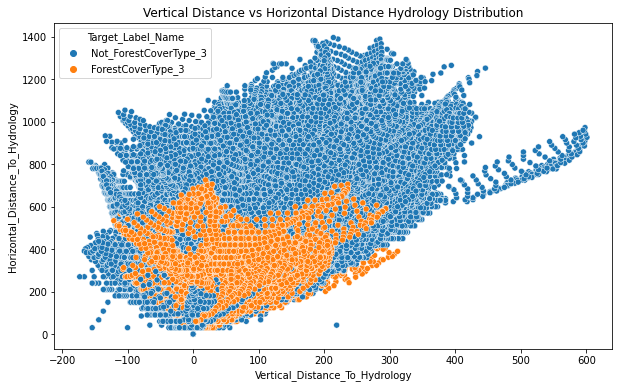

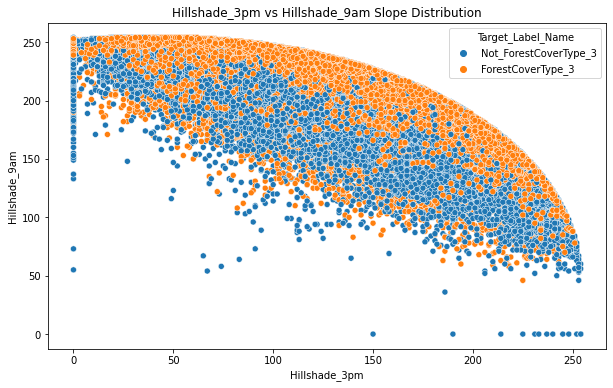

In [29]:
"""
There are variables which have linear relationship, but some of the varibales are having non linear tresnds where 
algorithms like Decision tree or ensemble model would work well.
"""
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Vertical_Distance_To_Hydrology", y="Horizontal_Distance_To_Hydrology",hue = 'Target_Label_Name',data=mainData)
plt.title('Vertical Distance vs Horizontal Distance Hydrology Distribution')

plt.figure(figsize=(10, 6))
sns.scatterplot(x="Hillshade_3pm", y="Hillshade_9am",hue = 'Target_Label_Name',data=mainData)
plt.title('Hillshade_3pm vs Hillshade_9am Slope Distribution')

In [30]:
"""
From the correlation matrix we saw that there are variables which are highly correlated 
leading to multicollinearity issues.These spurious variables can be detected and dropped 
using various methods such the VIF, dimension reduction by PCA, recursive feature 
elimination (RFE), fitting models with all variables and removing insignificant variables,
we could remove one of the variable, but we will be using one of the approach 
called Variance inflation factor where a variable having the highest VIF value shall be 
removed.
"""
def compute_vif(considered_features):
    
    X = mainData[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif
"""
Hillshade_3pm has a higher VIF value,indicating this varibale is explained by some other
independent varibale and acts a a redundant information.After removing the variable 
Hillshade_3pm, the vif values for other variables are within the acceptable range, we can go
ahead with the other features.
"""

modify_continuos = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3','Target_Label']
compute_vif(modify_continuos)

/Users/mdp/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mdp/.pyenv/versions/3.6.9/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/mdp/.pyenv/versions/3.6.9/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,Elevation,2.390964
1,Aspect,1.871271
2,Slope,1.860369
3,Horizontal_Distance_To_Hydrology,1.825435
4,Vertical_Distance_To_Hydrology,1.849253
5,Horizontal_Distance_To_Roadways,1.643754
6,Hillshade_9am,1.777397
7,Hillshade_Noon,1.809942
8,Horizontal_Distance_To_Fire_Points,1.294598
9,Wilderness_Area_0,inf


In [31]:
"""
Feature Engineering
Deriving new features from existing features.We will add new linear combinations of the 
numeric features and for some numeric feature mean value of the two variables could be 
added. 
"""

mainData['Distance_To_Hydrology'] = (mainData['Horizontal_Distance_To_Hydrology']**2 + mainData['Vertical_Distance_To_Hydrology']**2)**0.5
mainData['Mean_Elevation_Vertical_Distance_Hydrology'] = (mainData['Elevation'] + mainData['Vertical_Distance_To_Hydrology'])/2
mainData['Mean_Distance_Hydrology_Firepoints'] = (mainData['Horizontal_Distance_To_Hydrology'] + mainData['Horizontal_Distance_To_Fire_Points'])/2
mainData['Mean_Distance_Hydrology_Roadways'] = (mainData['Horizontal_Distance_To_Hydrology'] +  mainData['Horizontal_Distance_To_Roadways'])/2
mainData['Mean_Distance_Firepoints_Roadways'] = (mainData['Horizontal_Distance_To_Fire_Points'] +  mainData['Horizontal_Distance_To_Roadways'])/2
mainData


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_38,Soil_Type_39,Target,Target_Label,Target_Label_Name,Distance_To_Hydrology,Mean_Elevation_Vertical_Distance_Hydrology,Mean_Distance_Hydrology_Firepoints,Mean_Distance_Hydrology_Roadways,Mean_Distance_Firepoints_Roadways
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,5,0,Not_ForestCoverType_3,258.000000,1298.0,3268.5,384.0,3394.5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,5,0,Not_ForestCoverType_3,212.084889,1292.0,3218.5,301.0,3307.5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,2,0,Not_ForestCoverType_3,275.769832,1434.5,3194.5,1724.0,4650.5
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,2,0,Not_ForestCoverType_3,269.235956,1451.5,3226.5,1666.0,4650.5
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,5,0,Not_ForestCoverType_3,153.003268,1297.0,3162.5,272.0,3281.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,3,1,ForestCoverType_3,86.683332,1206.5,461.0,96.5,472.5
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,3,1,ForestCoverType_3,68.066144,1201.5,456.0,81.0,470.0
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,3,1,ForestCoverType_3,60.406953,1196.5,457.0,75.0,472.0
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,3,1,ForestCoverType_3,60.207973,1194.5,462.0,75.0,477.0


/Users/mdp/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/Users/mdp/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Users/mdp/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.sta

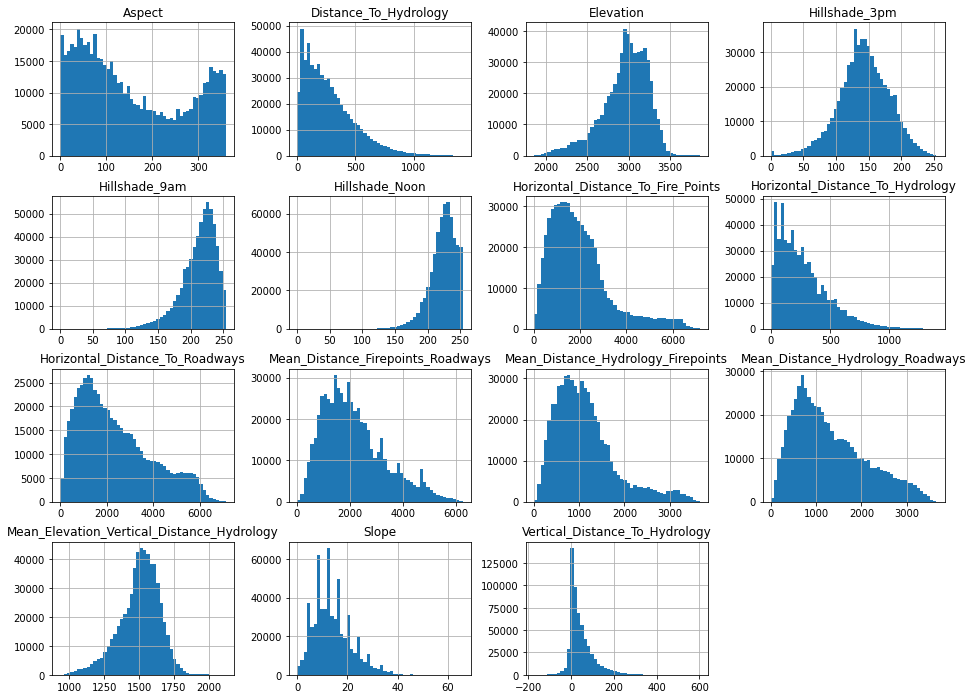

In [32]:
"""
Most of the numerical features are having a positive or negative skewed distribution, 
only 2 features Elevation and Hillshade_3pm are having normal distribtuion. This skewness 
in the data depicts that there are outliers present.Instead of removing the outliers, as removing them will cause
loss of data, we could use some transformation techniques like log, sqrt or power transformation to remove the 
skeweness from the data and shrink the outliers.

Feature Aspect has a bimodal distribution but to some extent has normal distribution.
Mean_Elevation_Vertical_Distance_Hydrology has almost
normal distribution.
"""
mainData.ix[:,['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points','Distance_To_Hydrology','Mean_Elevation_Vertical_Distance_Hydrology',
              'Mean_Distance_Hydrology_Firepoints','Mean_Distance_Hydrology_Roadways',
              'Mean_Distance_Firepoints_Roadways']].hist(figsize=(16,12),bins=50)
plt.show()


In [33]:
"""
Looking at the above data distribution and below skewness results, we see that most of the
features are skewed, except Aspect variables.The skewness value is between -0.5 to 0.5, which
is symmetrical. This indicates presence of outliers adn needs to hanlded carefully.
"""
mainData[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points','Distance_To_Hydrology','Mean_Elevation_Vertical_Distance_Hydrology',
              'Mean_Distance_Hydrology_Firepoints','Mean_Distance_Hydrology_Roadways',
              'Mean_Distance_Firepoints_Roadways']].skew()

Elevation                                    -0.817596
Aspect                                        0.402628
Slope                                         0.789273
Horizontal_Distance_To_Hydrology              1.140437
Vertical_Distance_To_Hydrology                1.790250
Horizontal_Distance_To_Roadways               0.713679
Hillshade_9am                                -1.181147
Hillshade_Noon                               -1.063056
Hillshade_3pm                                -0.277053
Horizontal_Distance_To_Fire_Points            1.288644
Distance_To_Hydrology                         1.133469
Mean_Elevation_Vertical_Distance_Hydrology   -0.575617
Mean_Distance_Hydrology_Firepoints            1.195706
Mean_Distance_Hydrology_Roadways              0.714797
Mean_Distance_Firepoints_Roadways             0.810207
dtype: float64

In [36]:
"""
After deriving new variables we see that the correlation of these new derived features with the target variables.
We see a good correlation.
"""
mainData.corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_37,Soil_Type_38,Soil_Type_39,Target,Target_Label,Distance_To_Hydrology,Mean_Elevation_Vertical_Distance_Hydrology,Mean_Distance_Hydrology_Firepoints,Mean_Distance_Hydrology_Roadways,Mean_Distance_Firepoints_Roadways
Elevation,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022,...,0.217179,0.193595,0.212612,-0.269554,-0.516612,0.298044,0.979944,0.193122,0.399736,0.325035
Aspect,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172,...,0.017706,0.008294,-0.005866,0.017080,0.047400,0.021169,0.029197,-0.104196,0.026979,-0.044721
Slope,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662,...,-0.072208,0.093602,0.025637,0.148285,0.227971,0.009286,-0.178262,-0.183513,-0.213322,-0.247175
Horizontal_Distance_To_Hydrology,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874,...,0.043031,0.031922,0.147020,-0.020317,-0.071264,0.998912,0.415703,0.208020,0.204474,0.076804
Vertical_Distance_To_Hydrology,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913,...,-0.008629,0.043859,0.179006,0.081664,0.070406,0.638161,0.289837,0.026832,0.035593,-0.069964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Distance_To_Hydrology,0.298044,0.021169,0.009286,0.998912,0.638161,0.064299,-0.037468,0.036901,0.052151,0.044659,...,0.040484,0.033015,0.151359,-0.014258,-0.062663,1.000000,0.414225,0.200783,0.196741,0.067635
Mean_Elevation_Vertical_Distance_Hydrology,0.979944,0.029197,-0.178262,0.415703,0.289837,0.342120,0.074544,0.175705,0.063842,0.128296,...,0.207040,0.194875,0.240205,-0.242769,-0.482512,0.414225,1.000000,0.191012,0.391377,0.298443
Mean_Distance_Hydrology_Firepoints,0.193122,-0.104196,-0.183513,0.208020,0.026832,0.336087,0.125683,0.063506,-0.038767,0.987598,...,-0.012570,0.001786,0.031845,-0.109890,-0.213740,0.200783,0.191012,1.000000,0.357673,0.777282
Mean_Distance_Hydrology_Roadways,0.399736,0.026979,-0.213322,0.204474,0.035593,0.991058,0.030087,0.192201,0.111148,0.332359,...,0.084052,0.037406,0.035423,-0.153317,-0.236180,0.196741,0.391377,0.357673,1.000000,0.842458


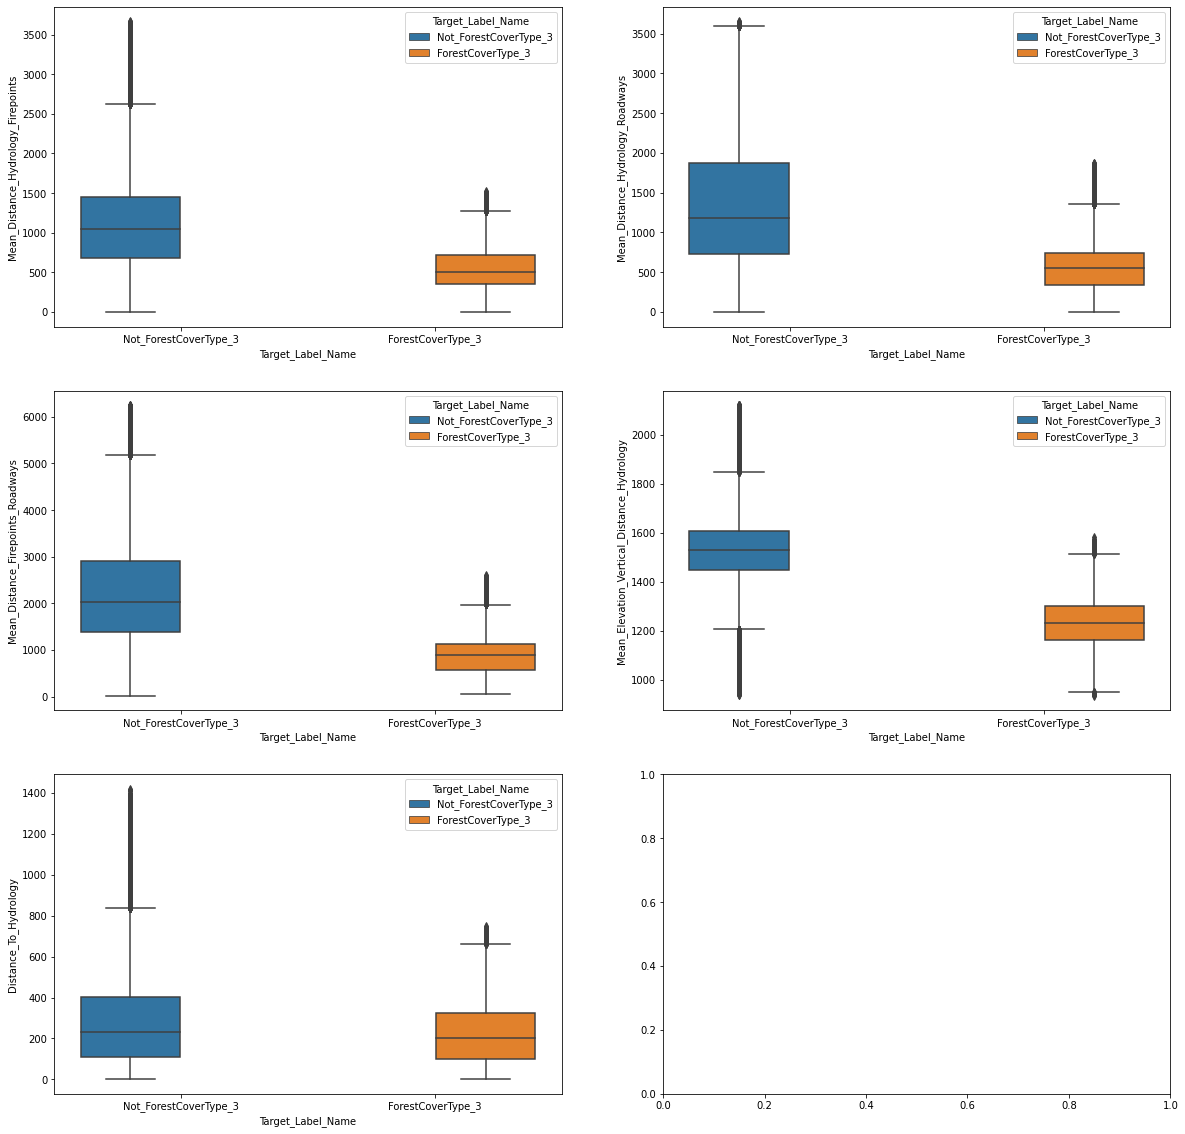

In [37]:
"""
Below box plots show cases that there is relation between the derived variables and the target variables.This 
variables would affect the outcome of the response. There is a difference in the sample mean of 2 groups.All the
derived varibales are related to target variables.
"""
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='Mean_Distance_Hydrology_Firepoints',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData, ax=axarr[0][0])
sns.boxplot(y='Mean_Distance_Hydrology_Roadways',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData, ax=axarr[0][1])
sns.boxplot(y='Mean_Distance_Firepoints_Roadways',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData, ax=axarr[1][0])
sns.boxplot(y='Mean_Elevation_Vertical_Distance_Hydrology',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData, ax=axarr[1][1])
sns.boxplot(y='Distance_To_Hydrology',x = 'Target_Label_Name', hue = 'Target_Label_Name',data = mainData, ax=axarr[2][0])





In [39]:
"""
Detecting outliers using interquartile range which measure the spread of data and identify the outliers, 
in thw data.Data points will be dropped if they lie more than the 3 times the interquartile range below the 
first quartile or above the third quartile.
"""
def outlier_detection(df, col_name):
    
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count



In [40]:

"""
We know that the wilderness area and soil type columns are one-hot encoded, we can focus on the rest features.
Hillshade columns are the RGB color representation of the shadow at a particular time so the range is already 
fixed between 0 and 255.

For other columns instead of removing the ouliers we 
shall try to transform the data using log ,sqrt or power transform to reduce the skewness and 
normalize the distribution of the data. We could remove the outlier but, we might loose some amount of data and 
looking at the current target class distribution, we already have less number of instances for positive class, we
will try to avoid this approach.

"""

numeric_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39']

for column in numeric_cols:
    if outlier_detection(mainData, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_detection(mainData, column)[2], column))



There are 275 outliers in Slope
There are 414 outliers in Horizontal_Distance_To_Hydrology
There are 5339 outliers in Vertical_Distance_To_Hydrology
There are 1027 outliers in Hillshade_9am
There are 1191 outliers in Hillshade_Noon
There are 10 outliers in Horizontal_Distance_To_Fire_Points
There are 29884 outliers in Wilderness_Area_1
There are 36968 outliers in Wilderness_Area_3
There are 3031 outliers in Soil_Type_0
There are 7525 outliers in Soil_Type_1
There are 4823 outliers in Soil_Type_2
There are 12396 outliers in Soil_Type_3
There are 1597 outliers in Soil_Type_4
There are 6575 outliers in Soil_Type_5
There are 105 outliers in Soil_Type_6
There are 179 outliers in Soil_Type_7
There are 1147 outliers in Soil_Type_8
There are 32634 outliers in Soil_Type_9
There are 12410 outliers in Soil_Type_10
There are 29971 outliers in Soil_Type_11
There are 17431 outliers in Soil_Type_12
There are 599 outliers in Soil_Type_13
There are 3 outliers in Soil_Type_14
There are 2845 outliers in 

In [45]:
mainData.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'S

In [46]:
mainData[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm','Target']].corr()

,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Target
Hillshade_9am,1.000000,0.010037,-0.780296,-0.035415
Hillshade_Noon,0.010037,1.000000,0.594274,-0.096426
Hillshade_3pm,-0.780296,0.594274,1.000000,-0.048290
Target,-0.035415,-0.096426,-0.048290,1.000000


In [47]:
"""
Dropping the 2 redundant features 'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology'
and Hillshade_3pm as this variable is highly correlated with other HillShade features 
and upon checking the VIF(Variancve Inflation Factor), the value is high compared to other Hillshade features, 
so we shall drop it beacuse this variable is explianed by the other indepenedent HillShade feature varibales..
"""
mainData.drop(['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Hillshade_3pm'],inplace=True,axis=1)
mainData



,Elevation,Aspect,Slope,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,...,Soil_Type_38,Soil_Type_39,Target,Target_Label,Target_Label_Name,Distance_To_Hydrology,Mean_Elevation_Vertical_Distance_Hydrology,Mean_Distance_Hydrology_Firepoints,Mean_Distance_Hydrology_Roadways,Mean_Distance_Firepoints_Roadways
0,2596,51,3,510,221,232,6279,1,0,0,...,0,0,5,0,Not_ForestCoverType_3,258.000000,1298.0,3268.5,384.0,3394.5
1,2590,56,2,390,220,235,6225,1,0,0,...,0,0,5,0,Not_ForestCoverType_3,212.084889,1292.0,3218.5,301.0,3307.5
2,2804,139,9,3180,234,238,6121,1,0,0,...,0,0,2,0,Not_ForestCoverType_3,275.769832,1434.5,3194.5,1724.0,4650.5
3,2785,155,18,3090,238,238,6211,1,0,0,...,0,0,2,0,Not_ForestCoverType_3,269.235956,1451.5,3226.5,1666.0,4650.5
4,2595,45,2,391,220,234,6172,1,0,0,...,0,0,5,0,Not_ForestCoverType_3,153.003268,1297.0,3162.5,272.0,3281.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,108,240,237,837,0,0,1,...,0,0,3,1,ForestCoverType_3,86.683332,1206.5,461.0,96.5,472.5
581008,2391,152,19,95,240,237,845,0,0,1,...,0,0,3,1,ForestCoverType_3,68.066144,1201.5,456.0,81.0,470.0
581009,2386,159,17,90,236,241,854,0,0,1,...,0,0,3,1,ForestCoverType_3,60.406953,1196.5,457.0,75.0,472.0
581010,2384,170,15,90,230,245,864,0,0,1,...,0,0,3,1,ForestCoverType_3,60.207973,1194.5,462.0,75.0,477.0


##### Further to the above results we can use different ML algorithms for identifying the relevant features, every algorithms has different criteria of providing feature importance.

##### In this task we will use Logistic Regression classifier model, which was used  earlier ,but in addition to this we could use other ensemble algorithms which has inbuild feature selections and we could compare the performance across different models.

##### From the above continuos variables distribution we see that variable are highly skewed, we applied log transformation on those variables and checked the skeweness and distribution. Applying log transformations on the variables,we observed that the data skeweness is not reduced, there is no much improvement in the data distribution.

##### We used other transformation techniques like power transformation which helped in increasing the symmetry of the distribution of the features as shown below.After applying transformations that data got symmetric,reason being the non linearity in the data.




In [48]:

pt = PowerTransformer()

mainData[['Elevation', 'Slope',
    'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon',
       'Horizontal_Distance_To_Fire_Points','Distance_To_Hydrology',
       'Mean_Elevation_Vertical_Distance_Hydrology',
       'Mean_Distance_Hydrology_Firepoints',
       'Mean_Distance_Hydrology_Roadways',
       'Mean_Distance_Firepoints_Roadways']] = pd.DataFrame(
    pt.fit_transform(mainData[['Elevation', 'Slope',
    'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon',
       'Horizontal_Distance_To_Fire_Points','Distance_To_Hydrology',
       'Mean_Elevation_Vertical_Distance_Hydrology',
       'Mean_Distance_Hydrology_Firepoints',
       'Mean_Distance_Hydrology_Roadways',
       'Mean_Distance_Firepoints_Roadways']]), columns=['Elevation', 'Slope',
    'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon',
       'Horizontal_Distance_To_Fire_Points','Distance_To_Hydrology',
       'Mean_Elevation_Vertical_Distance_Hydrology',
       'Mean_Distance_Hydrology_Firepoints',
       'Mean_Distance_Hydrology_Roadways',
       'Mean_Distance_Firepoints_Roadways']
)

## Checking the skewness of dat after transformation.
mainData[['Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon',
       'Horizontal_Distance_To_Fire_Points','Distance_To_Hydrology',
       'Mean_Elevation_Vertical_Distance_Hydrology',
       'Mean_Distance_Hydrology_Firepoints',
       'Mean_Distance_Hydrology_Roadways',
       'Mean_Distance_Firepoints_Roadways']].skew()

Elevation                                    -0.036368
Aspect                                        0.402628
Slope                                        -0.014085
Horizontal_Distance_To_Roadways              -0.070878
Hillshade_9am                                -0.147410
Hillshade_Noon                               -0.079582
Horizontal_Distance_To_Fire_Points            0.000418
Distance_To_Hydrology                        -0.107095
Mean_Elevation_Vertical_Distance_Hydrology    0.023397
Mean_Distance_Hydrology_Firepoints           -0.002478
Mean_Distance_Hydrology_Roadways             -0.048943
Mean_Distance_Firepoints_Roadways            -0.024131
dtype: float64

In [49]:
"""
Columns Wilderness Area and Soil Type features are one hot encoded,as all the categories 
are encoded there is a high risk of multicollinearity among the categorical variables, so 
we need to drop one of the category among n categories. Basically we generate 
one hot encoded vectors for n-1 categories.This is known as dummy variable trap problem.
As we alrady have the one hot encoded variable values, we shall exclude one of the category of that variables 
which is less correlated with target,avoiding multicollinearity.
"""
mainData.drop(['Wilderness_Area_2','Soil_Type_14'],inplace=True,axis=1)


In [50]:

X = mainData.drop(['Target','Target_Label'],axis=1)
Y = mainData['Target_Label']

numeric_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points',
               'Distance_To_Hydrology',
       'Mean_Elevation_Vertical_Distance_Hydrology',
       'Mean_Distance_Hydrology_Firepoints',
       'Mean_Distance_Hydrology_Roadways',
       'Mean_Distance_Firepoints_Roadways']

cat_cols = ['Wilderness_Area_0', 'Wilderness_Area_1',
       'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2',
       'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6',
       'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10',
       'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13',
       'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18',
       'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22',
       'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26',
       'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30',
       'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34',
       'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38',
       'Soil_Type_39']
X_train_lr, X_test_lr, Y_train_lr,Y_test_lr = train_test_split(X,Y, test_size = 0.20,stratify=Y)



In [51]:
"""
Feature scaling has been done to avoid the algorithm being biased towards the features having higher value in 
magnitude and as we are using Logistic Regression, scaling would make the gradient descent flow smooth and will 
reach the minima of the cost function.
"""
scaler = StandardScaler()
scaler.fit(X_train_lr[numeric_cols])

def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols]
    scaled_features_X = pd.DataFrame(X_numeric_scaled, index=df[numeric_cols].index, columns=df[numeric_cols].columns)
    X = pd.concat([scaled_features_X, X_categorical],axis=1)
    #y = target_y
    return X

X_scale_train = get_features_and_target_arrays(X_train_lr, numeric_cols, cat_cols, scaler)
X_scale_train


,Elevation,Aspect,Slope,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Distance_To_Hydrology,Mean_Elevation_Vertical_Distance_Hydrology,Mean_Distance_Hydrology_Firepoints,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
413304,0.655955,-1.238496,1.061595,-0.714298,-0.836303,-1.671927,-0.639541,0.376068,0.730705,-0.585930,...,0,0,0,0,0,0,0,0,0,0
113128,-0.211747,0.958737,-0.780313,1.540705,-0.663595,1.190380,-0.048164,-0.370389,-0.238725,-0.158347,...,0,0,0,0,0,0,0,0,0,0
234109,0.821865,1.717943,-0.606792,-0.160968,-0.553805,-0.062496,0.089668,-1.436403,0.607667,-0.122499,...,0,0,0,0,0,0,0,0,0,0
255849,-0.023995,-1.372473,-1.165352,-0.537895,-0.237268,0.112328,0.077439,-0.588919,-0.109299,-0.058412,...,1,0,0,0,0,0,0,0,0,0
556181,0.566033,-0.407835,0.134969,-2.135968,1.485490,-0.174609,1.299863,0.288301,0.564502,1.286747,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296851,-1.509764,-0.327448,-1.165352,-1.817377,0.720164,0.552705,-0.063000,-1.441215,-1.583504,-0.285464,...,0,0,0,0,0,0,0,0,0,0
242547,-2.482254,-1.167041,0.134969,-1.530183,-0.152514,-0.822445,-1.072984,-0.228475,-2.693102,-1.142886,...,0,0,0,0,0,0,0,0,0,0
448257,0.365193,0.521077,-1.382751,-1.300579,-0.065431,1.266499,0.017708,-0.106756,0.106521,-0.050846,...,0,0,0,0,0,0,0,0,0,0
19675,-1.060059,-0.184539,-1.622868,-0.060907,0.457045,0.756012,2.372297,-2.255903,-1.127437,2.275074,...,0,0,0,0,0,0,0,0,0,0


In [71]:
"""
Based on the optimal feature selection using Recursive feature selection using Cross validation, the average 
F1-score of the model is 73%. Finding the optimal number of features based on the scoring metric has taken longer
time to execute because of huge size of data and we are perfoming cross validation on every train test fold.
"""

rfecv = RFECV(estimator=lr_bal)
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', lr_bal)])
cv = StratifiedKFold(n_splits=10, random_state=42,shuffle=True)
n_scores = cross_val_score(pipeline, X_scale_train,Y_train_lr, scoring='f1', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.7361813423119625

In [72]:
pipeline.fit(X_scale_train,Y_train_lr)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=LogisticRegression(class_weight={0: 0.32326530612244897,
                                                                  1: 0.676734693877551},
                                                    random_state=42,
                                                    solver='liblinear'))),
                ('Model',
                 LogisticRegression(class_weight={0: 0.32326530612244897,
                                                  1: 0.676734693877551},
                                    random_state=42, solver='liblinear'))])

In [73]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 40


In [80]:
X_scale_train.shape

(464809, 54)

In [102]:
"""
Out of 54 features,the features that are relevant to the model performance are 40 features 
selected. This features are ranked based on how much they improve the model performance 
and here we whva used F1-score as an evaluation metric.In selecting the optimal number of 
features, the estimator is trained and the features are selected via the coefficients.
The least important features are removed. 

In addition the above approach, other that using Logistc Regrssion, we can use other tree 
based and ensemble based algorithms, fine tune the paramters and evaulate the model 
performance across different models and finalize based on that.

"""
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=X_scale_train.columns,columns=['Rank']).sort_values(by='Rank')
len(rfecv.support_rfecv_df[rfecv.support_rfecv_df['Rank'] == 1])
rfecv.support_rfecv_df = rfecv.support_rfecv_df.reset_index()
rfecv.support_rfecv_df.rename({'index':'Features'},inplace=True,axis=1)
rfecv.support_rfecv_df

#### The top features that shall used for model developement are as below:

'Elevation', 'Soil_Type_10',

'Soil_Type_12', 'Soil_Type_15',

'Soil_Type_16', 'Soil_Type_17', 

'Soil_Type_18', 'Soil_Type_19',

'Soil_Type_21', 'Soil_Type_22', 

'Soil_Type_23', 'Soil_Type_25',

'Soil_Type_26', 'Soil_Type_27', 

'Soil_Type_28', 'Soil_Type_29',

'Soil_Type_30', 'Soil_Type_31', 

'Soil_Type_32', 'Soil_Type_33',

'Soil_Type_9', 'Soil_Type_8',

'Soil_Type_11', 'Wilderness_Area_0',

'Distance_To_Hydrology',

'Mean_Elevation_Vertical_Distance_Hydrology',

'Mean_Distance_Hydrology_Firepoints',

'Mean_Distance_Hydrology_Roadways',

'Mean_Distance_Firepoints_Roadways', 'Aspect', 

'Hillshade_9am',
'Wilderness_Area_1', 'Horizontal_Distance_To_Roadways',

'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',

'Soil_Type_4', 'Soil_Type_5', 'Wilderness_Area_3', 'Soil_Type_38',

'Slope', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points',

'Soil_Type_20', 'Soil_Type_13', 'Soil_Type_37', 'Soil_Type_24',

'Soil_Type_7', 'Soil_Type_39', 'Soil_Type_6', 'Soil_Type_34',

'Soil_Type_36', 'Soil_Type_35'

